In [1]:
!wget 'https://storage.googleapis.com/writehere-13.appspot.com/mask_dataset.zip' -O /content/mask_dataset.zip

--2020-08-25 14:52:07--  https://storage.googleapis.com/writehere-13.appspot.com/mask_dataset.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 74.125.143.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 633971036 (605M) [application/zip]
Saving to: ‘/content/mask_dataset.zip’

/content/mask_datas 100%[===================>] 604.60M  56.0MB/s    in 14s     

2020-08-25 14:52:21 (44.6 MB/s) - ‘/content/mask_dataset.zip’ saved [633971036/633971036]



In [2]:
import zipfile,os
local_zip = 'mask_dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/dataset')
zip_ref.close()

In [3]:
!pip install split-folders
!pip install split-folders tqdm

In [4]:
import splitfolders
splitfolders.ratio('/content/dataset/', output="/content/project_data", ratio=(.8, .2))

Copying files: 20000 files [00:04, 4382.97 files/s]


In [9]:
base_dir = '/content/project_data/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

In [7]:
def read_list(directory):
  list_tag = []
  list_file = []
  for label in os.listdir(directory):
    for item in os.listdir(os.path.join(directory, label)):
      list_tag.append(label)
      list_file.append(os.path.join(directory, label, item))
  return pd.DataFrame({'tags': list_tag, 'filepath':list_file})

In [12]:
os.listdir(train_dir)

['new_with_mask', 'new_without_mask']

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.models import Sequential
from keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop

train_df = read_list(train_dir)
validation_df = read_list(validation_dir)

pd.set_option('display.max_colwidth', -1)
validation_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,tags,filepath
0,new_with_mask,/content/project_data/val/new_with_mask/with-mask-default-mask-seed5418.png
1,new_with_mask,/content/project_data/val/new_with_mask/with-mask-default-mask-seed9371.png
2,new_with_mask,/content/project_data/val/new_with_mask/with-mask-default-mask-seed8875.png
3,new_with_mask,/content/project_data/val/new_with_mask/with-mask-default-mask-seed8369.png
4,new_with_mask,/content/project_data/val/new_with_mask/with-mask-default-mask-seed2595.png
...,...,...
3995,new_without_mask,/content/project_data/val/new_without_mask/seed6180.png
3996,new_without_mask,/content/project_data/val/new_without_mask/seed0115.png
3997,new_without_mask,/content/project_data/val/new_without_mask/seed1475.png
3998,new_without_mask,/content/project_data/val/new_without_mask/seed9520.png


In [14]:
data_train_img_gen = ImageDataGenerator(
    rotation_range=20,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
  )

data_val_img_gen = ImageDataGenerator(
    rotation_range=20,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
  )

train_generator = data_train_img_gen.flow_from_dataframe(
    train_df,
    class_mode='categorical',
    x_col='filepath',
    y_col='tags',
    target_size=(150,150),
    batch_size=4
)

val_generator = data_val_img_gen.flow_from_dataframe(
    validation_df,
    class_mode='categorical',
    x_col='filepath',
    y_col='tags',
    target_size=(150,150),
    batch_size=4
)
print(train_generator.class_indices)

Found 16000 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.
{'new_with_mask': 0, 'new_without_mask': 1}


In [21]:
class modelCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.97 and logs.get('val_accuracy') > 0.97):
      print("\nReached 97.8% accuracy so cancelling training!")
      self.model.stop_training = True

In [22]:
callbacks = modelCallback()
model = Sequential()

model.add(Conv2D(32, (5,5), activation='relu', strides=(1,1), padding='valid', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(2, 2))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (5,5), activation='relu', strides=(1,1), padding='valid'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (5,5), activation='relu', strides=(1,1), padding='valid'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(2, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(learning_rate=0.001, rho=0.9),
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    steps_per_epoch=300,
    epochs=20,
    validation_data=val_generator,
    validation_steps=10,
    verbose=1,
    callbacks=[callbacks]
)

Epoch 1/20
300/300 [==============================] - 40s 132ms/step - loss: 0.5413 - accuracy: 0.7433 - val_loss: 1.3358 - val_accuracy: 0.4750
Epoch 2/20
300/300 [==============================] - ETA: 0s - loss: 0.1689 - accuracy: 0.9708
Reached 97.8% accuracy so cancelling training!
300/300 [==============================] - 40s 133ms/step - loss: 0.1689 - accuracy: 0.9708 - val_loss: 0.0070 - val_accuracy: 1.0000


1000/1000 [==============================] - 55s 55ms/step - loss: 0.0020 - accuracy: 0.9995
validasi akurasi: 99.95
validasi error:  0.20
4000/4000 [==============================] - 214s 54ms/step - loss: 0.0056 - accuracy: 0.9984
trainig akurasi: 99.84
training error:  0.56


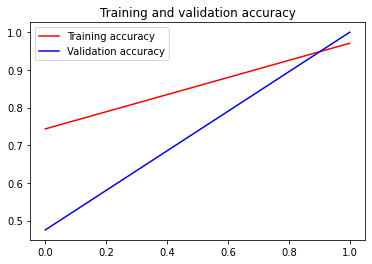

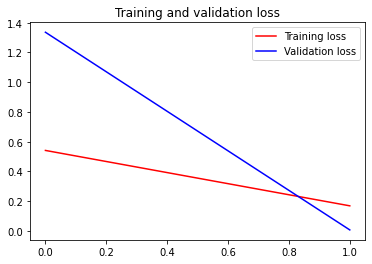

<Figure size 432x288 with 0 Axes>

In [23]:

loss, acc = model.evaluate(val_generator)
print("validasi akurasi: {:5.2f}".format(100 * acc))
print("validasi error: {:5.2f}".format(100 * loss))

t_loss, t_acc = model.evaluate(train_generator)
print("trainig akurasi: {:5.2f}".format(100 * t_acc))
print("training error: {:5.2f}".format(100 * t_loss))


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [24]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmp14lanxfi/assets


In [25]:
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)